In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import scipy.sparse
from pathlib import Path
import seaborn as sns

In [2]:
import scanpy as sc

data_dir = r"C:\Users\liamm\Desktop\GSE114724_RAW\GSM3148575"

adata = sc.read_10x_mtx(
    data_dir,
    var_names='gene_symbols',
    cache=True
)

adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 7096 × 33694
    var: 'gene_ids'

In [3]:
adata.X.shape #matrix of cells x genes

(7096, 33694)

## Doublet Removal

In [4]:
sc.pp.filter_genes(adata, min_cells = 10) #Keep genes that are found in at aleast 10 cells 

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3') #Keep only top 2000 variable genes

In [6]:
adata

AnnData object with n_obs × n_vars = 7096 × 2000
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [7]:
if scipy.sparse.issparse(adata.X):
    adata.X = adata.X.tocsr() #Dense matrix preferred over sparse for training
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [8]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.204. Signaling Trainer to stop.


In [9]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df

C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


doublet   singlet prediction
AAACCTGAGCAGACTG-1  0.041441  0.958559    singlet
AAACCTGAGGTCGGAT-1  0.074184  0.925816    singlet
AAACCTGAGTGTACCT-1  0.003509  0.996491    singlet
AAACCTGAGTGTACTC-1  0.000681  0.999319    singlet
AAACCTGAGTTAAGTG-1  0.041988  0.958011    singlet
...                      ...       ...        ...
TTTGTCACAGATGGGT-1  0.569068  0.430932    doublet
TTTGTCACAGGGATTG-1  0.006657  0.993343    singlet
TTTGTCAGTCCGACGT-1  0.021339  0.978661    singlet
TTTGTCAGTCCTAGCG-1  0.062197  0.937803    singlet
TTTGTCATCATCGATG-1  0.058543  0.941457    singlet

[7096 rows x 3 columns]

In [10]:
df.groupby('prediction').count()

doublet  singlet
prediction                  
doublet         694      694
singlet        6402     6402

In [11]:
df['dif'] = df.doublet - df.singlet
df

doublet   singlet prediction       dif
AAACCTGAGCAGACTG-1  0.041441  0.958559    singlet -0.917118
AAACCTGAGGTCGGAT-1  0.074184  0.925816    singlet -0.851632
AAACCTGAGTGTACCT-1  0.003509  0.996491    singlet -0.992983
AAACCTGAGTGTACTC-1  0.000681  0.999319    singlet -0.998639
AAACCTGAGTTAAGTG-1  0.041988  0.958011    singlet -0.916023
...                      ...       ...        ...       ...
TTTGTCACAGATGGGT-1  0.569068  0.430932    doublet  0.138136
TTTGTCACAGGGATTG-1  0.006657  0.993343    singlet -0.986686
TTTGTCAGTCCGACGT-1  0.021339  0.978661    singlet -0.957322
TTTGTCAGTCCTAGCG-1  0.062197  0.937803    singlet -0.875606
TTTGTCATCATCGATG-1  0.058543  0.941457    singlet -0.882914

[7096 rows x 4 columns]

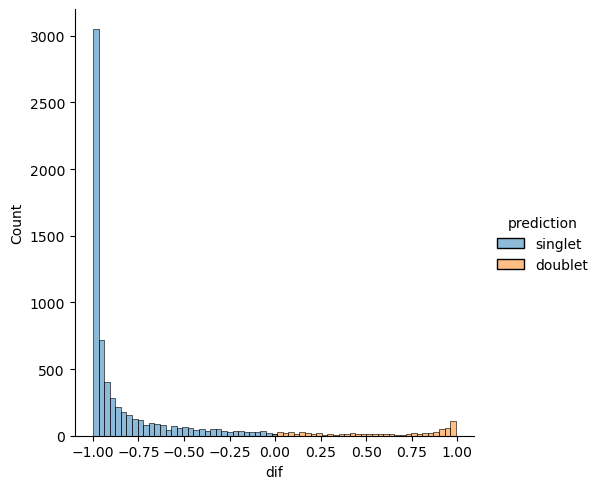

In [12]:
sns.displot(df, x='dif', hue='prediction')

In [13]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0)]
doublets

doublet   singlet prediction       dif
AAACCTGCAACACCCG-1  0.513267  0.486733    doublet  0.026534
AAAGCAATCTACCTGC-1  0.910461  0.089539    doublet  0.820923
AAAGTAGCACTAGTAC-1  0.874382  0.125618    doublet  0.748765
AAAGTAGTCCTGCCAT-1  0.935423  0.064577    doublet  0.870847
AAAGTAGTCTTTAGGG-1  0.586719  0.413281    doublet  0.173437
...                      ...       ...        ...       ...
TTTACTGCAGTCAGCC-1  0.988622  0.011378    doublet  0.977243
TTTATGCGTTAGGGTG-1  0.729564  0.270436    doublet  0.459128
TTTATGCTCTGCGACG-1  0.953092  0.046908    doublet  0.906184
TTTGCGCCACTTCTGC-1  0.647817  0.352183    doublet  0.295635
TTTGTCACAGATGGGT-1  0.569068  0.430932    doublet  0.138136

[694 rows x 4 columns]

In [14]:
adata = sc.read_10x_mtx(r"C:\Users\liamm\Desktop\GSE114724_RAW\GSM3148575")  #Reload the original non-filtered adata

In [15]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index) #Apply True or False if doublet to our original adata
adata

AnnData object with n_obs × n_vars = 7096 × 33694
    obs: 'doublet'
    var: 'gene_ids'

In [16]:
adata.obs

doublet
AAACCTGAGCAGACTG-1    False
AAACCTGAGGTCGGAT-1    False
AAACCTGAGTGTACCT-1    False
AAACCTGAGTGTACTC-1    False
AAACCTGAGTTAAGTG-1    False
...                     ...
TTTGTCACAGATGGGT-1     True
TTTGTCACAGGGATTG-1    False
TTTGTCAGTCCGACGT-1    False
TTTGTCAGTCCTAGCG-1    False
TTTGTCATCATCGATG-1    False

[7096 rows x 1 columns]

In [17]:
adata = adata[~adata.obs.doublet]

In [18]:
adata

View of AnnData object with n_obs × n_vars = 6402 × 33694
    obs: 'doublet'
    var: 'gene_ids'

# *Removed 805 doublets (7096 -> 6291 cells)*

# ----------------------------------------------------------------------------------

# Preprocessing

Removing mitochondrial and ribosomal genes 

In [19]:
adata.var[adata.var.index.str.startswith("MT-")]

gene_ids
MT-ND1   ENSG00000198888
MT-ND2   ENSG00000198763
MT-CO1   ENSG00000198804
MT-CO2   ENSG00000198712
MT-ATP8  ENSG00000228253
MT-ATP6  ENSG00000198899
MT-CO3   ENSG00000198938
MT-ND3   ENSG00000198840
MT-ND4L  ENSG00000212907
MT-ND4   ENSG00000198886
MT-ND5   ENSG00000198786
MT-ND6   ENSG00000198695
MT-CYB   ENSG00000198727

In [20]:
adata.var["mt"] = adata.var.index.str.startswith("MT-")

C:\Users\liamm\AppData\Local\Temp\ipykernel_31248\2277275628.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var.index.str.startswith("MT-")


In [21]:
adata.var

gene_ids     mt
RP11-34P13.3  ENSG00000243485  False
FAM138A       ENSG00000237613  False
OR4F5         ENSG00000186092  False
RP11-34P13.7  ENSG00000238009  False
RP11-34P13.8  ENSG00000239945  False
...                       ...    ...
AC233755.2    ENSG00000277856  False
AC233755.1    ENSG00000275063  False
AC240274.1    ENSG00000271254  False
AC213203.1    ENSG00000277475  False
FAM231B       ENSG00000268674  False

[33694 rows x 2 columns]

In [22]:
adata.var['mt'].value_counts()

mt
False    33681
True        13
Name: count, dtype: int64

In [23]:
#13 mt protein encoding genes in humans, so all selected

In [24]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
#List of ribosomal genes provided by the Broad Institute 

In [25]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

0
0          FAU
1       MRPL13
2        RPL10
3       RPL10A
4       RPL10L
..         ...
83        RPS9
84        RPSA
85     RSL24D1
86  RSL24D1P11
87       UBA52

[88 rows x 1 columns]

In [30]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [31]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [33]:
adata.var.sort_values('n_cells_by_counts')

gene_ids     mt   ribo  n_cells_by_counts  mean_counts  \
AC007325.2  ENSG00000277196  False  False                  0     0.000000   
AC007325.1  ENSG00000276017  False  False                  0     0.000000   
AC011043.2  ENSG00000278198  False  False                  0     0.000000   
AC011841.1  ENSG00000273496  False  False                  0     0.000000   
TTLL10      ENSG00000162571  False  False                  0     0.000000   
...                     ...    ...    ...                ...          ...   
HLA-B       ENSG00000234745  False  False               6390    29.485786   
MT-CO2      ENSG00000198712   True  False               6393    38.262574   
MT-ND4L     ENSG00000212907   True  False               6398    21.658076   
B2M         ENSG00000166710  False  False               6399    72.920806   
MALAT1      ENSG00000251562  False  False               6402    87.745704   

            pct_dropout_by_counts  total_counts  
AC007325.2             100.000000           0.0  
AC007325.1             100.000000           0.0  
AC011043.2             100.000000           0.0  
AC011841.1             100.000000           0.0  
TTLL10                 100.000000           0.0  
...                           ...           ...  
HLA-B                    0.187441      188768.0  
MT-CO2                   0.140581      244957.0  
MT-ND4L                  0.062480      138655.0  
B2M                      0.046860      466839.0  
MALAT1                   0.000000      561748.0  

[33694 rows x 7 columns]

In [34]:
sc.pp.filter_genes(adata, min_cells=3) #Remove genes that aren't in at least 3 cells

In [35]:
adata.var.sort_values('n_cells_by_counts')

gene_ids     mt   ribo  n_cells_by_counts  mean_counts  \
CTB-114C7.4   ENSG00000250274  False  False                  3     0.000625   
GPRIN1        ENSG00000169258  False  False                  3     0.000469   
PRR7-AS1      ENSG00000246334  False  False                  3     0.000469   
PCDH12        ENSG00000113555  False  False                  3     0.000469   
CTB-178M22.2  ENSG00000253978  False  False                  3     0.000625   
...                       ...    ...    ...                ...          ...   
HLA-B         ENSG00000234745  False  False               6390    29.485786   
MT-CO2        ENSG00000198712   True  False               6393    38.262574   
MT-ND4L       ENSG00000212907   True  False               6398    21.658076   
B2M           ENSG00000166710  False  False               6399    72.920806   
MALAT1        ENSG00000251562  False  False               6402    87.745704   

              pct_dropout_by_counts  total_counts  n_cells  
CTB-114C7.4               99.953140           4.0        3  
GPRIN1                    99.953140           3.0        3  
PRR7-AS1                  99.953140           3.0        3  
PCDH12                    99.953140           3.0        3  
CTB-178M22.2              99.953140           4.0        3  
...                             ...           ...      ...  
HLA-B                      0.187441      188768.0     6390  
MT-CO2                     0.140581      244957.0     6393  
MT-ND4L                    0.062480      138655.0     6398  
B2M                        0.046860      466839.0     6399  
MALAT1                     0.000000      561748.0     6402  

[15539 rows x 8 columns]

In [36]:
adata.obs.sort_values('n_genes_by_counts')

doublet  n_genes_by_counts  total_counts  total_counts_mt  \
CTGCTGTTCCGAATGT-1    False                482        1334.0             93.0   
TAGTGGTTCCCATTTA-1    False                487        1345.0            125.0   
ACTGCTCTCTGGCGAC-1    False                495        1237.0            194.0   
AGAGCTTAGCGTCTAT-1    False                511        1583.0            164.0   
GCCTCTACAGCTTAAC-1    False                518        1226.0            438.0   
...                     ...                ...           ...              ...   
CCTTTCTAGGCATGTG-1    False               3905       13346.0            342.0   
TGCCCATTCTATCCCG-1    False               4140       17038.0           1115.0   
AAAGCAAGTCCCGACA-1    False               4339       23680.0           1097.0   
CGAGCACTCTAACTCT-1    False               4381       18275.0            705.0   
ATTTCTGGTAAACCTC-1    False               5236       32210.0           1734.0   

                    pct_counts_mt  total_counts_ribo  pct_counts_ribo  
CTGCTGTTCCGAATGT-1       6.971514              595.0        44.602699  
TAGTGGTTCCCATTTA-1       9.293680              629.0        46.765797  
ACTGCTCTCTGGCGAC-1      15.683105              440.0        35.569927  
AGAGCTTAGCGTCTAT-1      10.360076              756.0        47.757423  
GCCTCTACAGCTTAAC-1      35.725941               14.0         1.141925  
...                           ...                ...              ...  
CCTTTCTAGGCATGTG-1       2.562566             2415.0        18.095310  
TGCCCATTCTATCCCG-1       6.544195             3681.0        21.604649  
AAAGCAAGTCCCGACA-1       4.632602             5444.0        22.989864  
CGAGCACTCTAACTCT-1       3.857729             3194.0        17.477428  
ATTTCTGGTAAACCTC-1       5.383421             5845.0        18.146538  

[6402 rows x 7 columns]

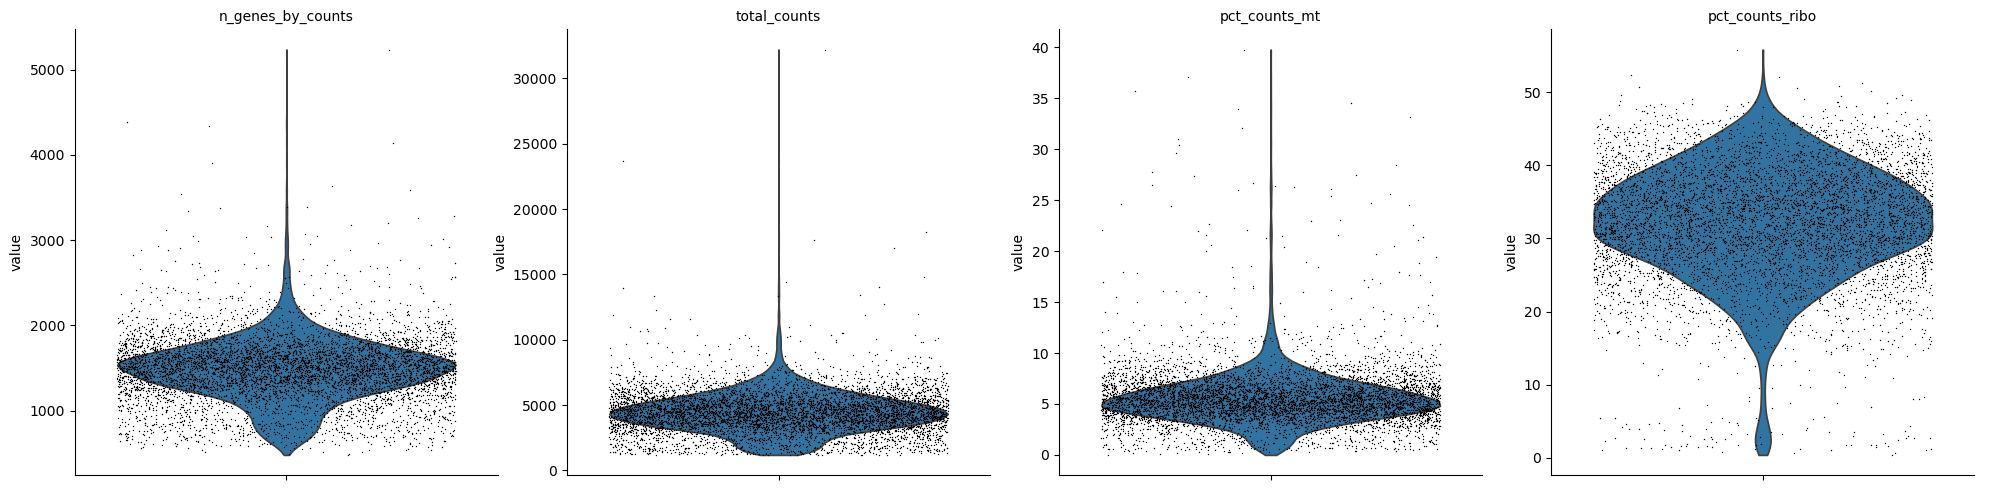

In [37]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [40]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim

np.float64(2297.819999999996)

In [42]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [43]:
adata.obs

doublet  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGCAGACTG-1    False               1685        4071.0            195.0   
AAACCTGAGGTCGGAT-1    False               1659        6346.0            250.0   
AAACCTGAGTGTACCT-1    False               1328        4110.0            281.0   
AAACCTGAGTGTACTC-1    False               1465        3394.0            118.0   
AAACCTGAGTTAAGTG-1    False               1289        3776.0            402.0   
...                     ...                ...           ...              ...   
TTTGTCACACCTGGTG-1    False               1585        5663.0            410.0   
TTTGTCACAGGGATTG-1    False               1476        4910.0            167.0   
TTTGTCAGTCCGACGT-1    False               1460        3647.0            236.0   
TTTGTCAGTCCTAGCG-1    False               1597        6215.0            311.0   
TTTGTCATCATCGATG-1    False               1710        5161.0            421.0   

                    pct_counts_mt  total_counts_ribo  pct_counts_ribo  
AAACCTGAGCAGACTG-1       4.789978              804.0        19.749447  
AAACCTGAGGTCGGAT-1       3.939489             2666.0        42.010715  
AAACCTGAGTGTACCT-1       6.836983             1551.0        37.737228  
AAACCTGAGTGTACTC-1       3.476724              515.0        15.173836  
AAACCTGAGTTAAGTG-1      10.646187             1277.0        33.818855  
...                           ...                ...              ...  
TTTGTCACACCTGGTG-1       7.239979             2097.0        37.029842  
TTTGTCACAGGGATTG-1       3.401222             1982.0        40.366600  
TTTGTCAGTCCGACGT-1       6.471072              871.0        23.882645  
TTTGTCAGTCCTAGCG-1       5.004023             2781.0        44.746582  
TTTGTCATCATCGATG-1       8.157333             1661.0        32.183685  

[6273 rows x 7 columns]

In [44]:
adata = adata[adata.obs.pct_counts_mt < 20] #Remove cells with > 20% mt reads 

# Normalization

In [47]:
sc.pp.normalize_total(adata, target_sum=1e4) #Normalize every cell to 10,000 UMI

C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [49]:
adata.X.sum(axis = 1) #UMIs per each cell

matrix([[10000.   ],
        [10000.001],
        [10000.   ],
        ...,
        [10000.   ],
        [ 9999.999],
        [10000.001]], dtype=float32)

In [51]:
sc.pp.log1p(adata) #Convert to log counts

In [52]:
adata.X.sum(axis = 1)

matrix([[2669.517 ],
        [2211.6736],
        [2125.8057],
        ...,
        [2403.1116],
        [2121.302 ],
        [2447.0376]], dtype=float32)

In [ ]:
adata.raw = adata

# Clustering

In [53]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [54]:
adata.var

gene_ids     mt   ribo  n_cells_by_counts  mean_counts  \
RP11-34P13.7   ENSG00000238009  False  False                  6     0.000937   
FO538757.3     ENSG00000279928  False  False                 14     0.002187   
FO538757.2     ENSG00000279457  False  False                755     0.128085   
AP006222.2     ENSG00000228463  False  False                 51     0.008122   
RP4-669L17.10  ENSG00000237094  False  False                  8     0.001250   
...                        ...    ...    ...                ...          ...   
AC011043.1     ENSG00000276256  False  False                110     0.017651   
AL592183.1     ENSG00000273748  False  False                 26     0.004061   
AL354822.1     ENSG00000278384  False  False                 43     0.006717   
AC233755.1     ENSG00000275063  False  False                  3     0.000469   
AC240274.1     ENSG00000271254  False  False                  7     0.001093   

               pct_dropout_by_counts  total_counts  n_cells  highly_variable  \
RP11-34P13.7               99.906279           6.0        6             True   
FO538757.3                 99.781318          14.0       14             True   
FO538757.2                 88.206810         820.0      755            False   
AP006222.2                 99.203374          52.0       51            False   
RP4-669L17.10              99.875039           8.0        8             True   
...                              ...           ...      ...              ...   
AC011043.1                 98.281787         113.0      110            False   
AL592183.1                 99.593877          26.0       26            False   
AL354822.1                 99.328335          43.0       43            False   
AC233755.1                 99.953140           3.0        3            False   
AC240274.1                 99.890659           7.0        7            False   

                  means  dispersions  dispersions_norm  
RP11-34P13.7   0.002484     1.286641          1.186144  
FO538757.3     0.004649     1.184861          0.729999  
FO538757.2     0.255915     1.011086         -0.048798  
AP006222.2     0.016525     0.953864         -0.305249  
RP4-669L17.10  0.002646     1.152841          0.586497  
...                 ...          ...               ...  
AC011043.1     0.039039     1.005518         -0.073755  
AL592183.1     0.009370     1.044803          0.102309  
AL354822.1     0.016784     1.089311          0.301778  
AC233755.1     0.001360     1.106059          0.376837  
AC240274.1     0.002449     0.799725         -0.996046  

[15539 rows x 12 columns]

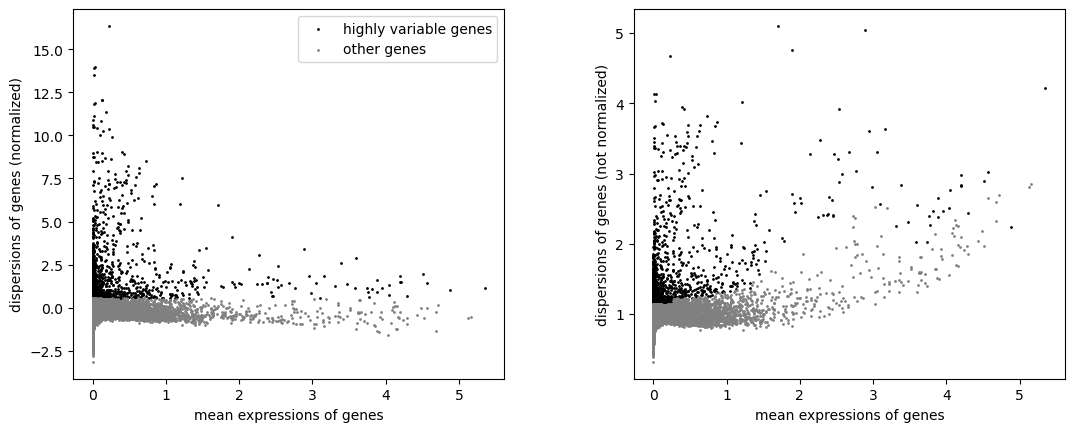

In [55]:
sc.pl.highly_variable_genes(adata)

In [56]:
adata = adata[:, adata.var.highly_variable]

In [57]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\preprocessing\_simple.py:729: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\preprocessing\_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\preprocessing\_simple.py:667: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


In [58]:
sc.pp.scale(adata, max_value=10)

In [59]:
sc.tl.pca(adata, svd_solver='arpack')

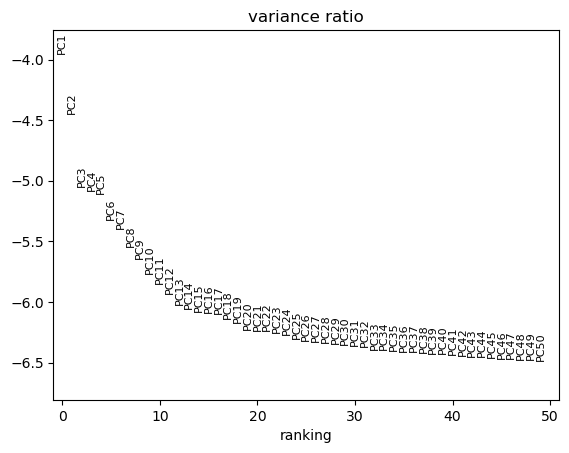

In [60]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [61]:
sc.pp.neighbors(adata, n_pcs = 30) #Flattens most ~30, use for clustering

In [62]:
sc.tl.umap(adata) #Calculates co-ords 

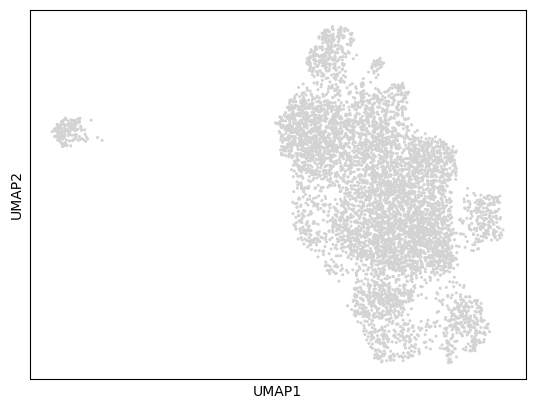

In [63]:
sc.pl.umap(adata)

In [65]:
sc.tl.leiden(adata, resolution = 0.5)

C:\Users\liamm\AppData\Local\Temp\ipykernel_31248\3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


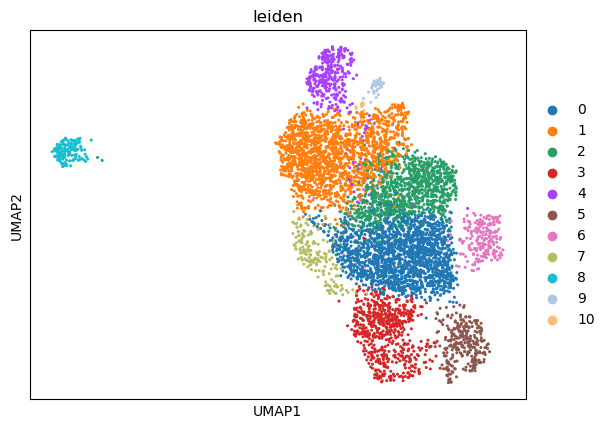

In [66]:
sc.pl.umap(adata, color=['leiden'])

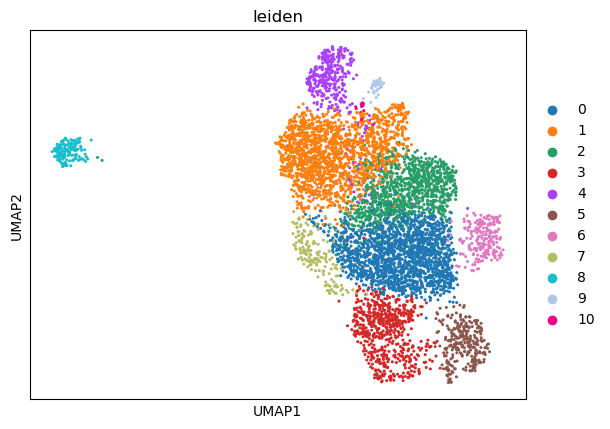

In [70]:
#Re-colour cluster 10 for improved visibility
adata.obs['leiden'] = adata.obs['leiden'].astype('category')
i = list(adata.obs['leiden'].cat.categories).index('10')
cols = list(adata.uns['leiden_colors'])
cols[i] = '#EF008C'   
adata.uns['leiden_colors'] = cols

sc.pl.umap(adata, color='leiden')

In [ ]:
#Leiden resolution of 0.5 looks good

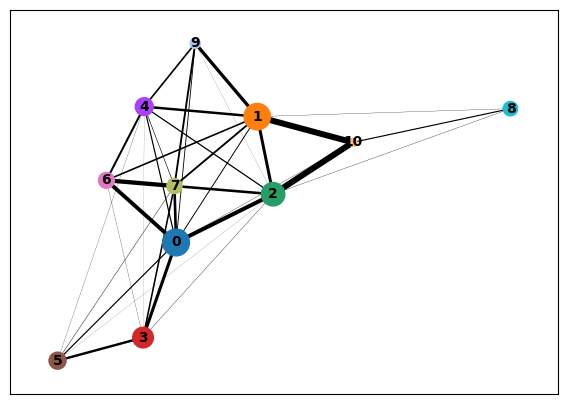

In [67]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata)

In [71]:
 #Strong inter-cluster neighbour links between 1-10, and 2-10

# Integration

C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.184. Signaling Trainer to stop.


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model ini

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.180. Signaling Trainer to stop.


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model ini

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.245. Signaling Trainer to stop.


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model ini

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.182. Signaling Trainer to stop.


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model ini

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scvi\data\fields\_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.160. Signaling Trainer to stop.


C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_d

Training:   0%|          | 0/286 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=286` reached.


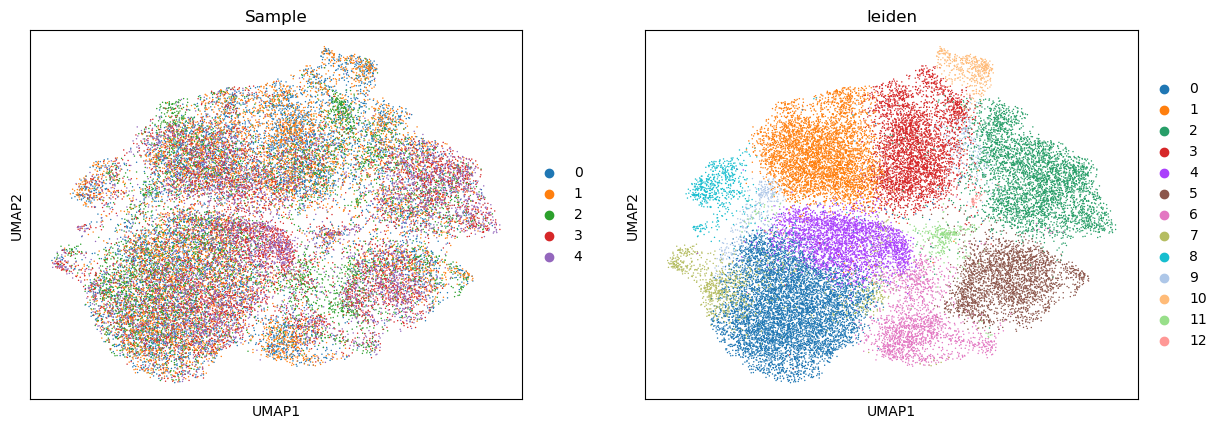

In [92]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy import io as spio
import scvi

BASE = Path(r"C:\Users\liamm\Desktop\matrix_files")

#Read one triplet: matrixN.mtx + barcodesN + genesN
def read_flat_triplet(mtx_path: str | Path) -> ad.AnnData:
    p = Path(mtx_path)
    m = re.match(r"matrix(\d+)\.mtx$", p.name, flags=re.IGNORECASE)
    if not m:
        raise ValueError(f"Expect matrixN.mtx, got {p.name}")
    idx = m.group(1)

    barc = next(iter(p.parent.glob(f"barcodes{idx}*")), None)
    feats = (next(iter(p.parent.glob(f"features{idx}*")), None)
             or next(iter(p.parent.glob(f"genes{idx}*")), None))
    if barc is None or feats is None:
        raise FileNotFoundError(f"Missing barcodes{idx}* or genes/features{idx}* next to {p}")

    X = spio.mmread(p).tocsr().T  # genes x cells -> cells x genes
    barcodes = pd.read_csv(barc, sep="\t", header=None).iloc[:, 0].astype(str).values
    gdf = pd.read_csv(feats, sep="\t", header=None)
    var_names = (gdf.iloc[:, 1] if gdf.shape[1] >= 2 else gdf.iloc[:, 0]).astype(str).values

    a = ad.AnnData(X=X)
    a.obs_names = barcodes
    a.var_names = var_names
    a.var_names_make_unique()
    a.obs["Sample"] = f"matrix{idx}"
    return a

# Per-sample preprocess: SOLO + QC
def pp(mtx_path: str | Path) -> ad.AnnData:
    a = read_flat_triplet(mtx_path)

    # SOLO on raw counts
    scvi.model.SCVI.setup_anndata(a)          
    vae = scvi.model.SCVI(a); vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae); solo.train()
    df = solo.predict(); df["prediction"] = solo.predict(soft=False)
    df.index = df.index.str.replace(r"-\d+$", "", regex=True)
    a_bases = a.obs_names.str.replace(r"-\d+$", "", regex=True)
    df["dif"] = df.doublet - df.singlet
    doublets = set(df[(df.prediction == "doublet") & (df.dif > 1)].index)
    a.obs["doublet"] = a_bases.isin(doublets)
    a = a[~a.obs.doublet].copy()

    # Light QC (no harsh ribo filter)
    sc.pp.filter_cells(a, min_genes=200)
    a.var["mt"]   = a.var_names.str.upper().str.startswith(("MT-","MT_"))
    a.var["ribo"] = a.var_names.str.upper().str.match(r"^(RPS|RPL)")
    sc.pp.calculate_qc_metrics(a, qc_vars=["mt","ribo"], inplace=True)
    upper = np.quantile(a.obs.n_genes_by_counts.values, 0.98)
    a = a[a.obs.n_genes_by_counts < upper].copy()
    a = a[a.obs.pct_counts_mt < 20].copy()

    return a

#Build list of per-sample objects
adatas = [pp(p) for p in sorted(BASE.glob("matrix*.mtx"))]

# ---- Concatenate; keep RAW COUNTS in a layer for HVGs + scVI ----
adata = ad.concat(adatas, label="Sample", join="outer", fill_value=0)
adata.layers["counts"] = adata.X.copy()   # <- raw integer counts preserved

# HVGs on raw counts (seurat_v3 expects integers); exclude ribosomal genes
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="Sample",
    layer="counts",              
)
# Drop ribosomal genes from HVGs to avoid ribo-driven clusters
if "ribo" not in adata.var.columns:
    adata.var["ribo"] = adata.var_names.str.upper().str.match(r"^(RPS|RPL)")
hvg_mask = adata.var["highly_variable"].values & ~adata.var["ribo"].fillna(False).values
adata = adata[:, hvg_mask].copy()

# Train scVI on RAW COUNTS 
scvi.model.SCVI.setup_anndata(adata, batch_key="Sample", layer="counts")  # *** key change ***
m = scvi.model.SCVI(adata)
m.train()   # optionally: m.train(max_epochs=150)

# Use latent for graph/UMAP/Leiden
adata.obsm["X_scVI"] = m.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.6)
sc.pl.umap(adata, color=["Sample","leiden"])

In [93]:
#Left, UMAP coloured by batch, right coloured by clusters

In [155]:
adata.shape

(28009, 2990)

In [97]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7450882 stored elements and shape (28009, 2990)>

In [103]:
adata.write_h5ad('integrated_set.h5ad')

# Labelling Cell Types

In [150]:
adata

AnnData object with n_obs × n_vars = 28009 × 2990
    obs: 'Sample', '_scvi_batch', '_scvi_labels', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'ribo'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [163]:
sc.tl.rank_genes_groups(adata, 'leiden', layer='scvi_normalized', method='wilcoxon')

C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\liamm\anaconda3\envs\torch_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [162]:
markers_scvi

proba_m1  proba_m2  bayes_factor        scale1    scale2  \
GZMK          0.9622    0.0378      3.236913  7.713455e-03  0.002223   
GZMM          0.9502    0.0498      2.948657  1.487605e-03  0.000679   
LINC00384     0.9370    0.0630      2.699548  3.112057e-05  0.000004   
SAMD3         0.9350    0.0650      2.666159  6.671767e-04  0.000258   
CST7          0.9330    0.0670      2.633712  5.061293e-03  0.001384   
...              ...       ...           ...           ...       ...   
AC018816.3    0.0380    0.9620     -3.231428  2.624638e-06  0.000027   
NEFM          0.0370    0.9630     -3.259135  4.973523e-07  0.000009   
SLC18A2       0.0280    0.9720     -3.547151  7.260620e-08  0.000005   
KLRB1         0.0272    0.9728     -3.576961  1.467984e-04  0.001170   
ADM           0.0144    0.9856     -4.226022  3.072094e-08  0.000012   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
GZMK        10.670114   2.414333               0.987651   
GZMM         1.892405   0.936139               0.789904   
LINC00384    0.013584   0.001440               0.010960   
SAMD3        0.799321   0.289908               0.520068   
CST7         6.106360   1.871952               0.962797   
...               ...        ...                    ...   
AC018816.3   0.000000   0.024063               0.000000   
NEFM         0.000000   0.001180               0.000000   
SLC18A2      0.000000   0.001037               0.000000   
KLRB1        0.048780   0.871711               0.048780   
ADM          0.000000   0.001323               0.000000   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
GZMK                     0.375134             95.498129             18.683590   
GZMM                     0.519066             16.896600              6.973727   
LINC00384                0.001347              0.125262              0.012537   
SAMD3                    0.215317              7.217578              2.245060   
CST7                     0.514839             54.936822             13.294981   
...                           ...                   ...                   ...   
AC018816.3               0.021989              0.000000              0.168012   
NEFM                     0.001073              0.000000              0.010138   
SLC18A2                  0.000965              0.000000              0.007510   
KLRB1                    0.240382              0.314707              6.257966   
ADM                      0.000894              0.000000              0.009521   

            comparison group1 group2  
GZMK         0 vs Rest      0   Rest  
GZMM         0 vs Rest      0   Rest  
LINC00384    0 vs Rest      0   Rest  
SAMD3        0 vs Rest      0   Rest  
CST7         0 vs Rest      0   Rest  
...                ...    ...    ...  
AC018816.3  12 vs Rest     12   Rest  
NEFM        12 vs Rest     12   Rest  
SLC18A2     12 vs Rest     12   Rest  
KLRB1       12 vs Rest     12   Rest  
ADM         12 vs Rest     12   Rest  

[38870 rows x 14 columns]

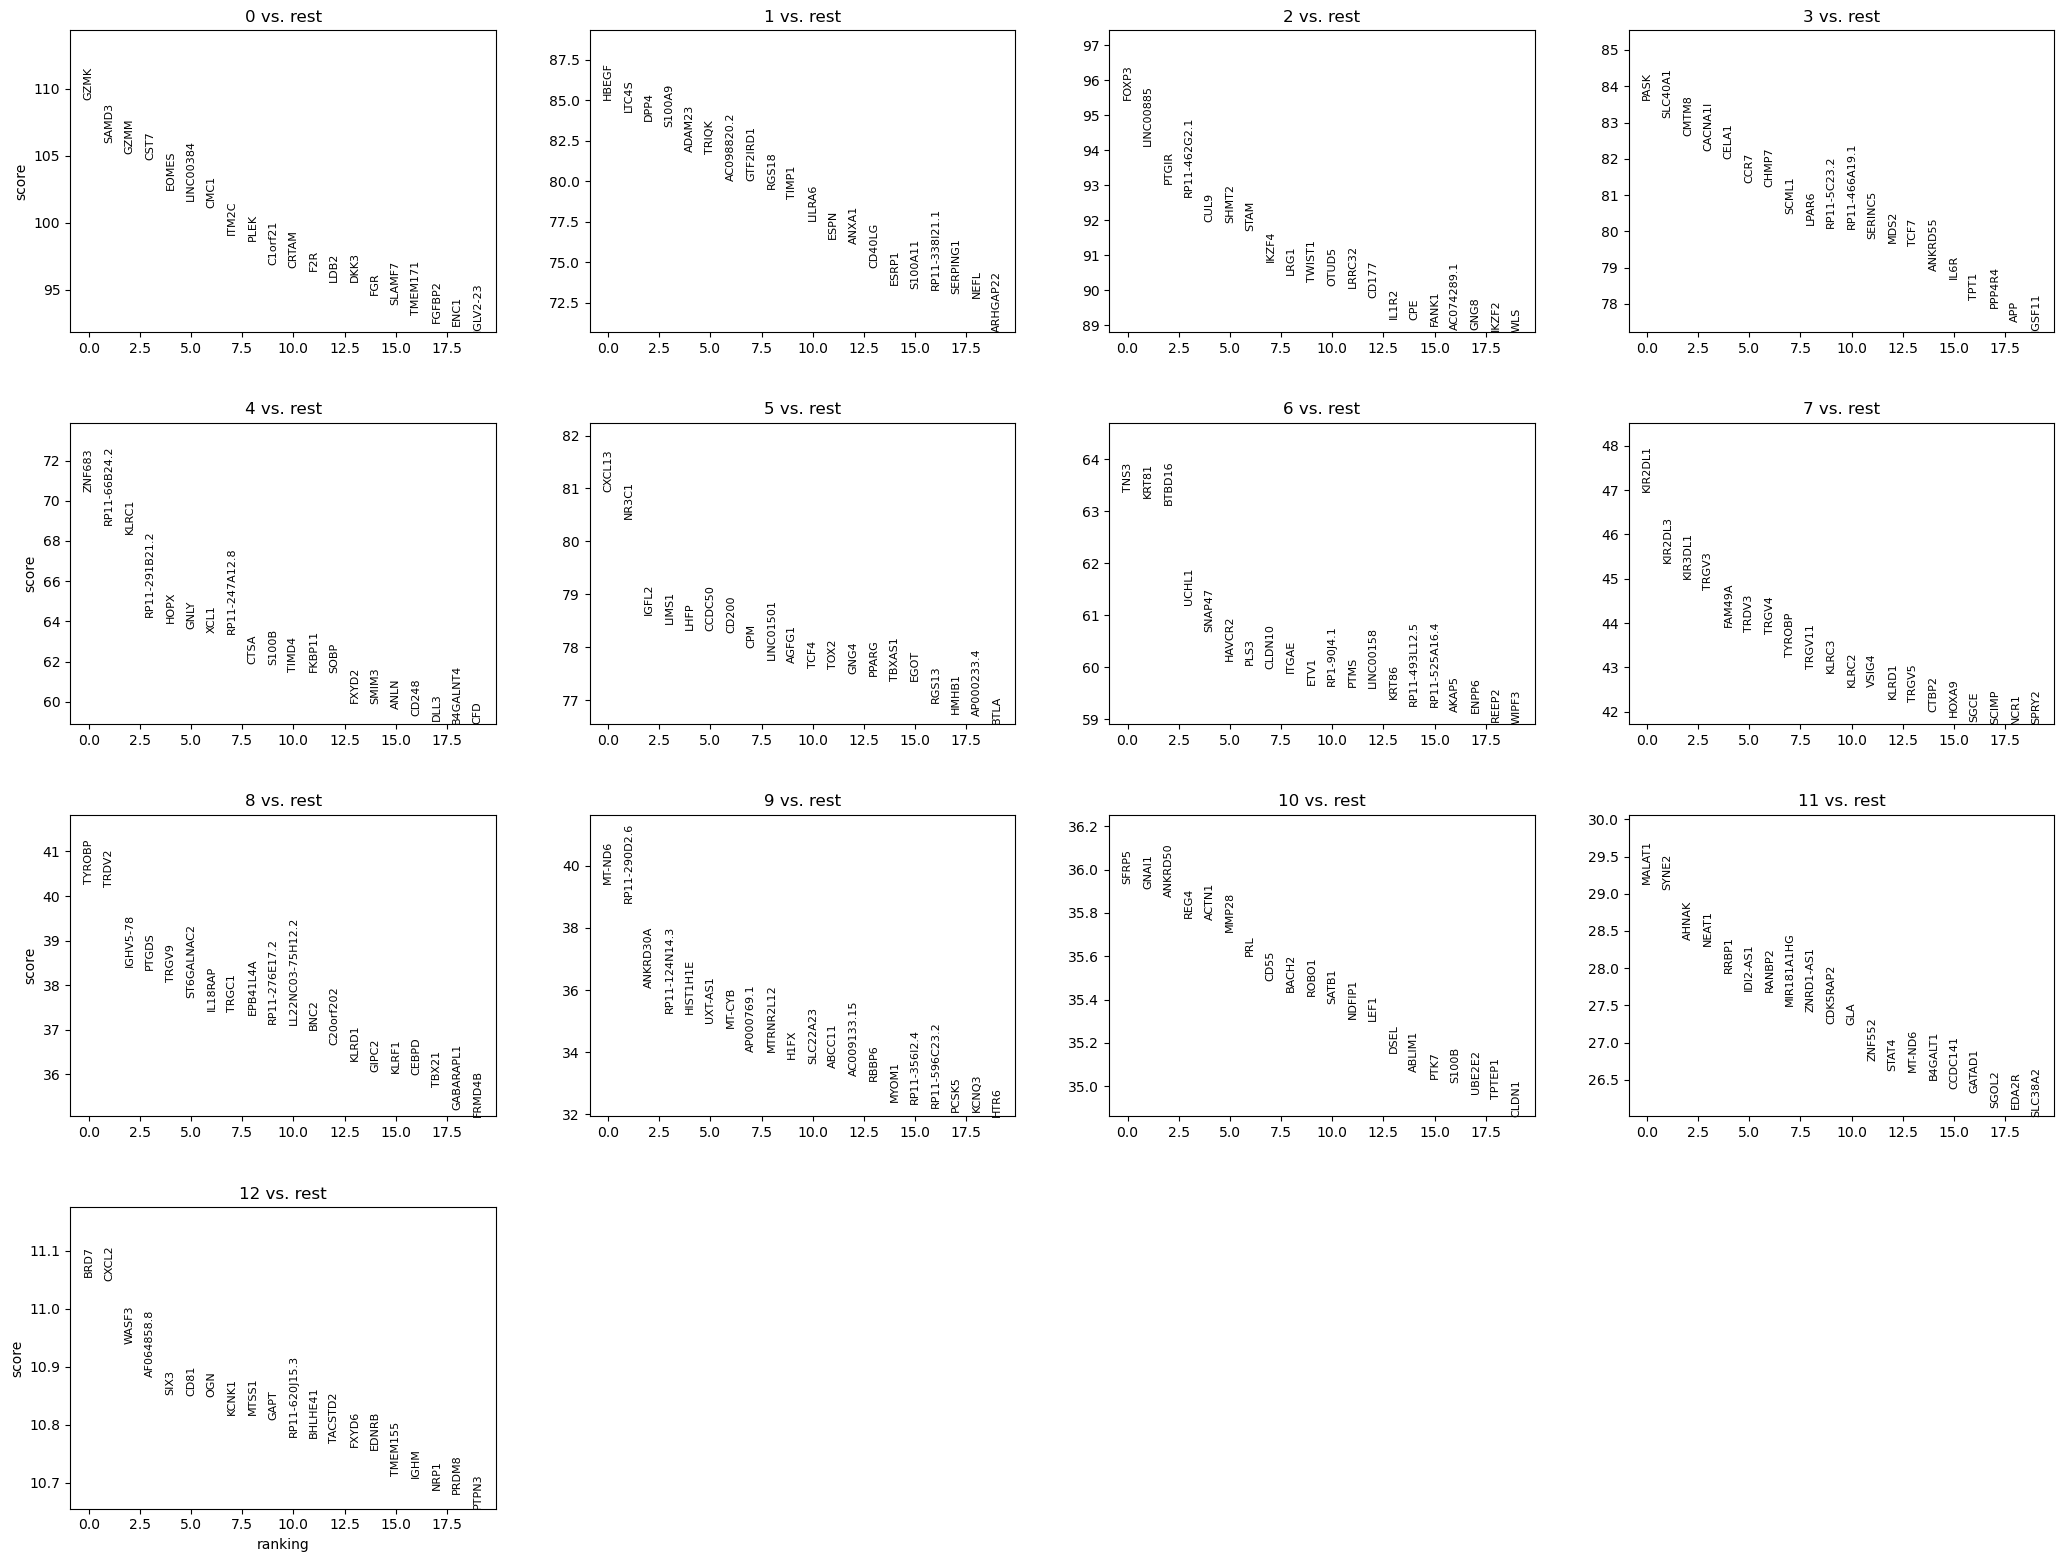

In [164]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)

In [ ]:
#Highest left = most sig

In [167]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
markers

group         names      scores  logfoldchanges     pvals  pvals_adj
0         0          GZMK  109.178223       82.902847  0.000000   0.000000
1         0         SAMD3  105.951775        5.877010  0.000000   0.000000
2         0          GZMM  105.130318       12.215353  0.000000   0.000000
3         0          CST7  104.699684       55.080597  0.000000   0.000000
4         0         EOMES  102.458488        8.023977  0.000000   0.000000
...     ...           ...         ...             ...       ...        ...
37313    12         TRDV2    2.157861        0.636751  0.030939   0.041142
37315    12         CEBPA    2.153203        0.928563  0.031303   0.041558
37317    12          KRT8    2.151096        1.015669  0.031469   0.041726
37324    12         PVRL2    2.086421        1.773609  0.036941   0.048550
38052    12  CH17-224D4.2   -2.150555        1.556561  0.031511   0.041764

[10753 rows x 6 columns]

In [179]:
markers_scvi = m.differential_expression(groupby = 'leiden') 
markers_scvi

DE...:   0%|          | 0/13 [00:00<?, ?it/s]

proba_m1  proba_m2  bayes_factor        scale1    scale2  raw_mean1  \
GZMK       0.9468    0.0532      2.879029  8.067600e-03  0.002297  10.670114   
SAMD3      0.9388    0.0612      2.730455  6.605018e-04  0.000254   0.799321   
CST7       0.9314    0.0686      2.608396  5.213939e-03  0.001370   6.106360   
EOMES      0.9258    0.0742      2.523894  7.679654e-04  0.000217   0.836215   
GZMM       0.9242    0.0758      2.500830  1.519544e-03  0.000677   1.892405   
...           ...       ...           ...           ...       ...        ...   
TCEAL2     0.0310    0.9690     -3.442277  3.882689e-07  0.000011   0.000000   
GADD45G    0.0282    0.9718     -3.539828  6.426216e-06  0.000111   0.000000   
KLRB1      0.0272    0.9728     -3.576961  1.456765e-04  0.001137   0.048780   
SLC18A2    0.0238    0.9762     -3.713981  4.916676e-08  0.000005   0.000000   
ADM        0.0134    0.9866     -4.299009  2.467179e-08  0.000013   0.000000   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
GZMK      2.414333               0.987651               0.375134   
SAMD3     0.289908               0.520068               0.215317   
CST7      1.871952               0.962797               0.514839   
EOMES     0.189819               0.480086               0.117505   
GZMM      0.936139               0.789904               0.519066   
...            ...                    ...                    ...   
TCEAL2    0.005077               0.000000               0.004505   
GADD45G   0.103332               0.000000               0.059389   
KLRB1     0.871711               0.048780               0.240382   
SLC18A2   0.001037               0.000000               0.000965   
ADM       0.001323               0.000000               0.000894   

         raw_normalized_mean1  raw_normalized_mean2  comparison group1 group2  
GZMK                95.498129             18.683590   0 vs Rest      0   Rest  
SAMD3                7.217578              2.245060   0 vs Rest      0   Rest  
CST7                54.936822             13.294981   0 vs Rest      0   Rest  
EOMES                7.305649              1.410386   0 vs Rest      0   Rest  
GZMM                16.896600              6.973727   0 vs Rest      0   Rest  
...                       ...                   ...         ...    ...    ...  
TCEAL2               0.000000              0.040116  12 vs Rest     12   Rest  
GADD45G              0.000000              0.630786  12 vs Rest     12   Rest  
KLRB1                0.314707              6.257966  12 vs Rest     12   Rest  
SLC18A2              0.000000              0.007510  12 vs Rest     12   Rest  
ADM                  0.000000              0.009521  12 vs Rest     12   Rest  

[38870 rows x 14 columns]

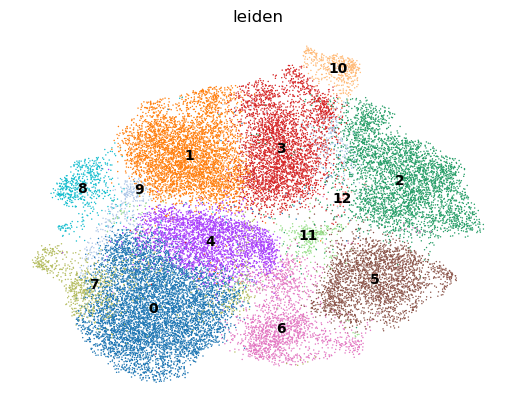

In [180]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

In [182]:
marker_genes_to_plot = ['GZMK', 'CST7']

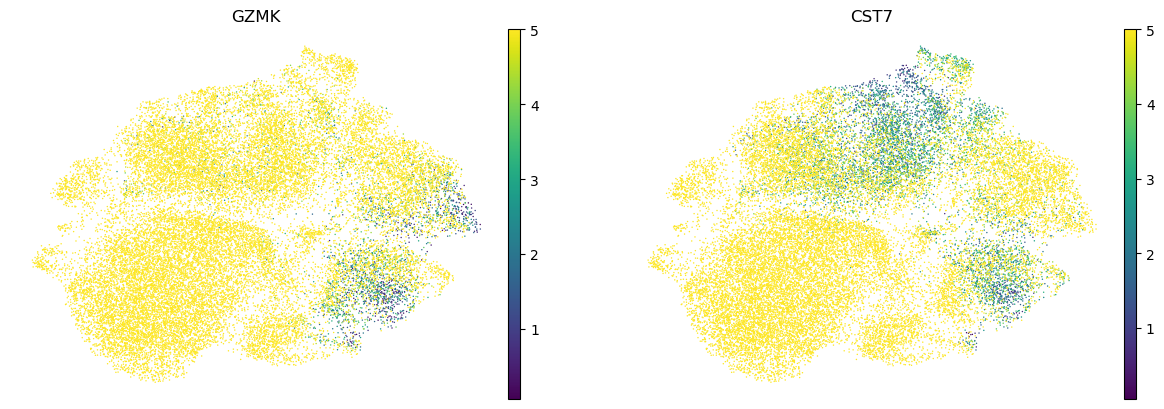

In [183]:
sc.pl.umap(
    adata,
    color=marker_genes_to_plot,
    layer='scvi_normalized',  
    frameon=False,
    vmax=5  
)

In [184]:
!pip install celltypist

   ---------------------------------------- 0.0/7.3 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.3 MB 6.3 MB/s eta 0:00:01
   ----------- ---------------------------- 2.1/7.3 MB 6.2 MB/s eta 0:00:01
   -------------------- ------------------- 3.7/7.3 MB 6.2 MB/s eta 0:00:01
   ---------------------------- ----------- 5.2/7.3 MB 6.5 MB/s eta 0:00:01
   ----------------------------------- ---- 6.6/7.3 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 7.3/7.3 MB 6.6 MB/s eta 0:00:00

   -------------------- ------------------- 2/4 [openpyxl]
   -------------------- ------------------- 2/4 [openpyxl]
   -------------------- ------------------- 2/4 [openpyxl]
   -------------------- ------------------- 2/4 [openpyxl]
   -------------------- ------------------- 2/4 [openpyxl]
   ------------------------------ --------- 3/4 [celltypist]
   ---------------------------------------- 4/4 [celltypist]



In [187]:
import celltypist

In [188]:
celltypist.models.download_models()

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in C:\Users\liamm\.celltypist\data\models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_Bloo

In [197]:
import celltypist
# pick a log-scale matrix for scoring
if 'scvi_log1p' in adata.layers:
    SCORE_LAYER = 'scvi_log1p'
elif 'scvi_normalized' in adata.layers:
    adata.layers['scvi_log1p'] = np.log1p(adata.layers['scvi_normalized'])
    SCORE_LAYER = 'scvi_log1p'
else:
    SCORE_LAYER = None
    if 'log1p' not in adata.uns:
        sc.pp.log1p(adata)  # ensure adata.X is log1p if no scVI layer


In [198]:
MARKERS = {
    # epithelial / tumor
    "Epithelial (KRT/EPCAM)": ["EPCAM","KRT8","KRT18","KRT14","KRT5","KRT17","KRT7"],
    "Basal-like epithelial":   ["KRT5","KRT14","KRT17","ITGA6","TP63"],
    "Cycling":                 ["MKI67","TOP2A","STMN1","PCNA","TYMS"],
    # lymphoid
    "CD8 T":                   ["CD3D","CD3E","CD8A","CD8B","GZMB","PRF1"],
    "CD4 T":                   ["CD3D","CD3E","IL7R","CCR7","TCF7"],
    "Treg":                    ["FOXP3","IL2RA","IKZF2","CTLA4","TNFRSF18"],
    "NK":                      ["NKG7","GNLY","KLRD1","KLRB1","GZMB","PRF1"],
    "B cell":                  ["MS4A1","CD74","CD79A","CD19","BANK1"],
    "Plasma":                  ["MZB1","JCHAIN","SDC1","XBP1"],
    # myeloid / DC
    "Mono classical":          ["LYZ","S100A8","S100A9","VCAN","CTSS"],
    "Mono nonclassical":       ["LYZ","FCGR3A","MS4A7","LST1"],
    "Macrophage":              ["C1QA","C1QB","C1QC","APOE","CST3","MARCO"],
    "cDC2":                    ["FCER1A","CLEC10A","HLA-DRA","CD1C"],
    "cDC1":                    ["XCR1","CLEC9A","BATF3","IRF8"],
    "pDC":                     ["GZMB","IRF7","LILRA4","PLD4","TCF4"],
    "Mast":                    ["TPSAB1","CPA3","KIT","GATA2"],
    # stroma / vessels
    "Endothelial":             ["PECAM1","VWF","KDR","KLF2","ESAM"],
    "Pericyte/SMC":            ["RGS5","PDGFRB","ACTA2","TAGLN","MYL9"],
    "Fibroblast/CAF":          ["COL1A1","COL1A2","DCN","LUM","COL3A1","PDPN"],
    # other
    "Erythroid":               ["HBB","HBA1","ALAS2"],
    "Immune (PTPRC)":          ["PTPRC"],  # helpful gating feature
}

# case-insensitive keep-only genes present in this dataset
varU = pd.Index(adata.var_names.str.upper())
to_real = {u:o for u,o in zip(varU, adata.var_names)}
def present(genes): return [to_real[g] for g in map(str.upper, genes) if g in to_real]
MARKERS = {k: present(v) for k,v in MARKERS.items() if present(v)}


In [199]:

for name, genes in MARKERS.items():
    sc.tl.score_genes(
        adata, gene_list=genes, score_name=f"score_{name}",
        use_raw=False, layer=SCORE_LAYER,
        ctrl_size=min(50, max(5, 2*len(genes)))
    )


clusters = adata.obs['leiden'].astype(str)
score_cols = [c for c in adata.obs.columns if c.startswith("score_")]
cluster_scores = adata.obs.groupby(clusters)[score_cols].mean()


base_cols = [c for c in score_cols if c != "score_Cycling"]
best = cluster_scores[base_cols].idxmax(axis=1).str.replace("score_","", regex=False)


if "score_Cycling" in cluster_scores:
    margin = 0.15  # stricter -> increase; laxer -> decrease
    cycling = cluster_scores["score_Cycling"] >= (cluster_scores[base_cols].max(axis=1) - margin)
    best = best.where(~cycling, best + " (cycling)")


label_map = best.to_dict()
adata.obs['cell_type'] = adata.obs['leiden'].map(label_map).astype('category')


label_map


{'0': 'NK',
 '1': 'Plasma',
 '10': 'CD4 T',
 '11': 'Plasma',
 '12': 'cDC2',
 '2': 'Treg',
 '3': 'CD4 T',
 '4': 'NK',
 '5': 'pDC',
 '6': 'cDC2',
 '7': 'NK',
 '8': 'NK',
 '9': 'Plasma'}

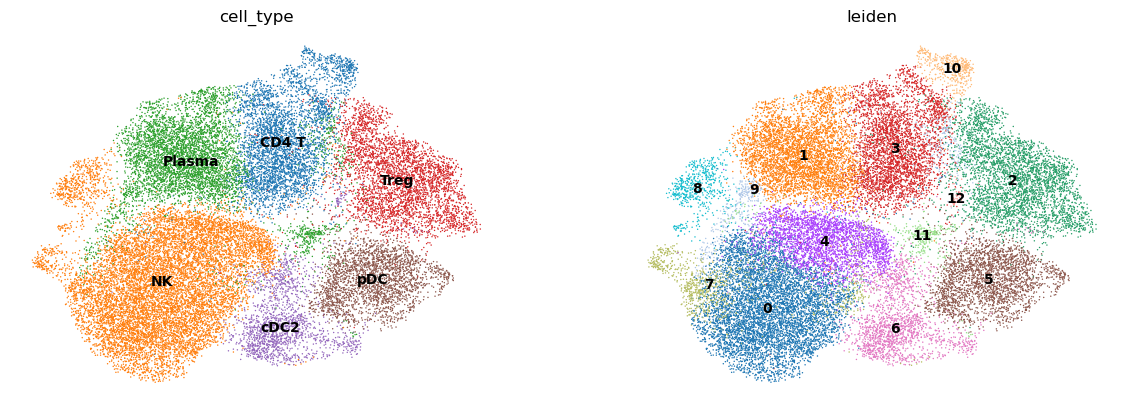

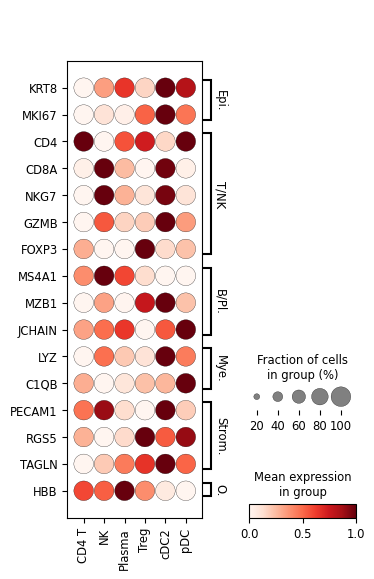

In [200]:
# UMAP with auto labels
sc.pl.umap(adata, color=["cell_type","leiden"], frameon=False, legend_loc="on data")


panel = {
    "Epithelial": ["EPCAM","KRT8","KRT14","KRT17","MKI67"],
    "T/NK":       ["CD3D","CD4","CD8A","NKG7","GZMB","FOXP3"],
    "B/Plasma":   ["MS4A1","MZB1","JCHAIN"],
    "Myeloid/DC": ["LYZ","C1QB","FCER1A","XCR1","LILRA4"],
    "Stroma/Vess":["PECAM1","VWF","RGS5","PDGFRB","COL1A1","TAGLN"],
    "Other":      ["TPSAB1","CPA3","HBB"],
}

panel = {k:[g for g in v if g in adata.var_names] for k,v in panel.items()}

sc.pl.dotplot(
    adata,
    var_names=panel,             
    groupby="cell_type",
    standard_scale="var",
    layer=SCORE_LAYER,
    swap_axes=True
)


In [204]:
#All immune cells is a good sign

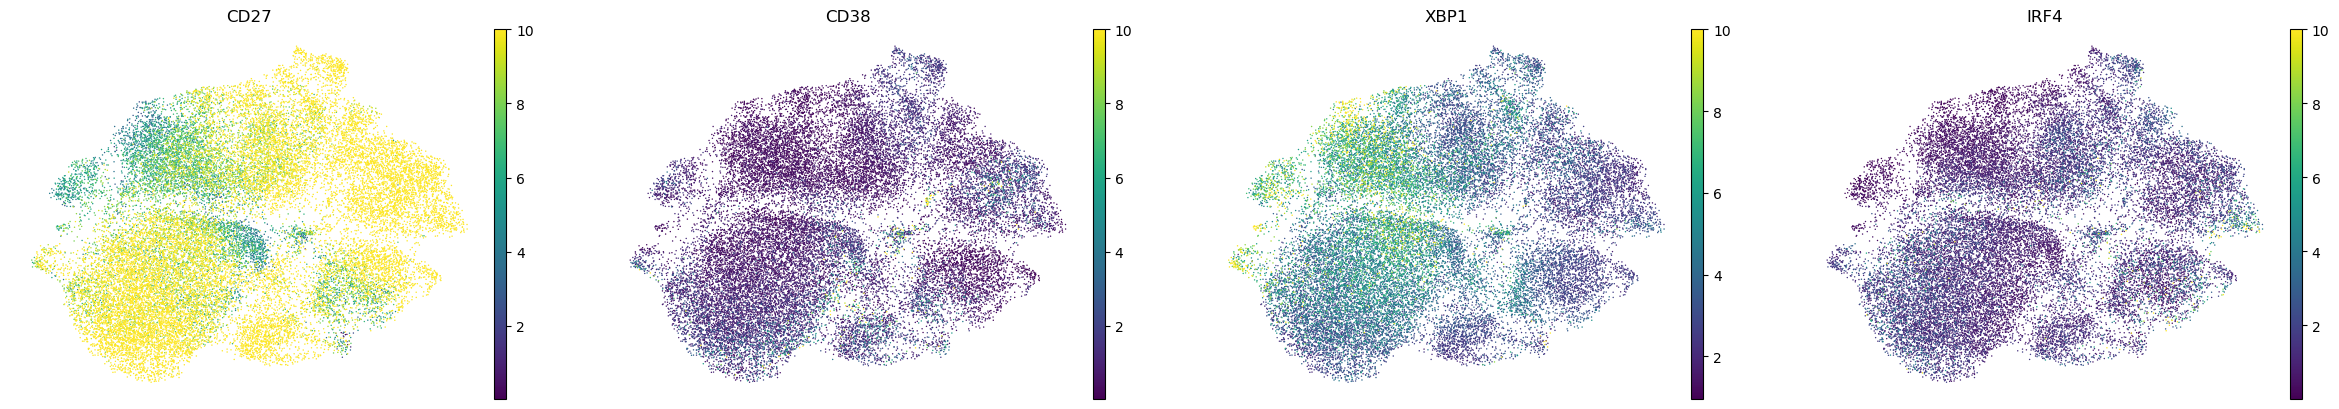

In [215]:
import scanpy as sc

# A list of B cell and Plasma cell markers
b_cell_markers = ['CD27', 'CD38', 'XBP1', 'IRF4']


sc.pl.umap(
    adata,
    color=b_cell_markers,
    layer='scvi_normalized',
    frameon=False,
    vmax=10,  
    
)